In [62]:
module MclWorld

using Plots
using Distributions
using LinearAlgebra
using Printf

include("../scripts/robot.jl")
import .RealRobotWorld: RealRobot, RealCamera
import .RealRobotWorld: Agent, Landmark, Map, Camera, Robot, World
import .RealRobotWorld: data, decision, state_transition, circle_shape, draw, append

mutable struct Particle
    pose::Array{Float64}

    function Particle(
        pose)

        new(
            pose
        )
    end

end

mutable struct Mcl
    init_pose::Array{Float64}
    num::Int64
    particles::Array{Particle}
    motion_noise_rate_pdf::MvNormal

    function Mcl(
        init_pose,
        num;
        particles=[Particle(init_pose) for i in 1:num],
        motion_noise_stds::Dict   
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            num,
            particles,
            motion_noise_rate_pdf
        )
    end

end

function draw(self::Mcl, plt)    
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3]) for p in self.particles]
    vys = [sin(p.pose[3]) for p in self.particles]
    quiver!(plt, xs, ys, quiver=(vxs, vys))
end

function motion_update(self::Mcl, nu, omega, time)
   print(cov(self.motion_noise_rate_pdf)) 
end

mutable struct EstimationAgent <: Agent
    time_interval::Float64
    nu::Float64
    omega::Float64
    estimator::Mcl

    function EstimationAgent(
        time_interval,
        nu,
        omega,
        estimator)

        new(
            time_interval,
            nu, 
            omega,
            estimator
        )
    end
end

function draw(self::RealRobot, plt)
    x, y, theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    push!(self.poses, deepcopy(self.pose))

    plot!(plt, [x, xn], [y, yn], c=self.color, label="")
    plot!(plt, circle_shape(x, y, self.r), seriestype=[:shape,], c=self.color, linecolor=:black, fillalpha=0.2, aspectratio=1, label="")
    plot!(plt, [p[1] for p in self.poses], [p[2] for p in self.poses], c=self.color, label="") 

    if length(self.sensor.map.landmarks) > 0
        draw(self.sensor, self.poses[end-1], plt) #1ステップ前の姿勢を使用; self.sensor.lastdataに対応させるため
    end

    draw(self.agent, plt) # added
end

function draw(self::EstimationAgent, plt)    
    draw(self.estimator, plt)
end

end


Main.MclWorld

[0.0001 0.0 0.0 0.0; 0.0 0.0004 0.0 0.0; 0.0 0.0 0.0009 0.0; 0.0 0.0 0.0 0.0016]

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
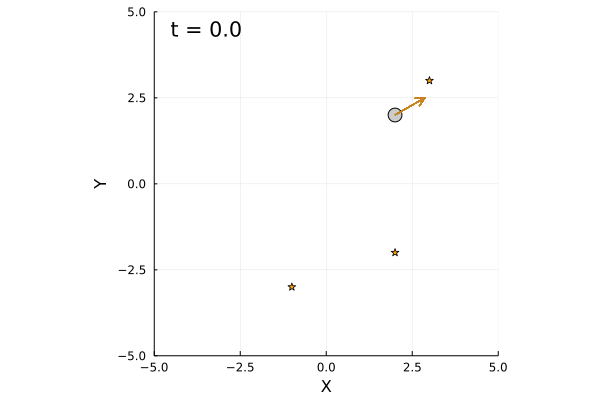

In [64]:
world = MclWorld.World(10, 1)

### 地図を生成して３つランドマークを追加 ###
m = MclWorld.Map()
MclWorld.append(m, MclWorld.Landmark([2, -2]))
MclWorld.append(m, MclWorld.Landmark([-1, -3]))
MclWorld.append(m, MclWorld.Landmark([3, 3]))
MclWorld.append(world, m)

initial_pose = [2, 2, pi/6]
estimator = MclWorld.Mcl(initial_pose, 100, motion_noise_stds=Dict([("nn", 0.01), ("no", 0.02), ("on", 0.03), ("oo", 0.04)]))

circling = MclWorld.EstimationAgent(0.1, 0.2, 10.0/180.0*pi, estimator)
MclWorld.motion_update(estimator, 0.2, 10/180.0*pi, 0.1)

r = MclWorld.RealRobot(initial_pose, :black, 0.2, circling)
MclWorld.append(world, r)

### アニメーション実行 ###
MclWorld.draw(world)